This script performs several setps of time series analyis

First section: Order selection for ARIMAX model based on lowest AIC and BIC

Second section: Testing for model performance improvement in terms of MAPE, RMSE, and Accuracy in predicting the right return sign.

Note that the aim of our research is not to identify multicollinearity, endogeneity. The purpose is to test whether the predictive power of classical ARMAX models can be improved by including our sentiment score as an exogenous variable.


In [1]:
import pandas as pd
import numpy as np
import pickle
import random
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


import warnings
warnings.filterwarnings('ignore')
random.seed(42)

df = pd.read_csv("./tsdata/modeldata.csv", index_col='Date', parse_dates=True)
df.index.freq = "MS"

train = df[:'2020-01-01']
test = df['2020-01-02':]


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#Model fitting
y = train['returns']
X_msci = train[["msci"]]
X_sent = train[["sentiment"]] #"sentiment" is our own sentiment score derived fromt the sentiment LDA
X_both = train[["msci", "sentiment"]]#Both the MSCI and the sentiment score are included


ytest = test["returns"]

Xmsci_test = test[["msci"]]
Xsent_test = test[["sentiment"]]
Xboth_test = test[["msci", "sentiment"]]

#function for MAPE
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

#function for RMSE
def rmse(actual, pred):
    return np.sqrt(mean_squared_error(actual, pred))

#function to evaluate the ARMAX model for a given order (p, 0, q)
def evaluateModel(data, exog, order, actual, exogtest):
    model = SARIMAX(data, exog=exog, order=(order[0], 0, order[1]), enforce_stationarity=True, enforce_invertibility=True)
    model_fit = model.fit(disp=False, maxiter = 300)
    prediction = model_fit.get_forecast(steps=len(ytest), exog=exogtest).predicted_mean
    MAPE_f = mape(actual, prediction)
    RMSE_f = rmse(actual, prediction)
    return order, model_fit.aic, model_fit.bic, MAPE_f, RMSE_f

#set range for considered (p, q) order
orders = [(p, q) for p in range(5) for q in range(5) if (p, q) != (0, 0)]

results_base = []
results_msci = []
results_sent = []
results_both = []

#Base model
for order in orders:
    try:
        order, aic, bic, MAPE_base, RMSE_base = evaluateModel(y, None, order, ytest, None)
        results_base.append([order, aic, bic, MAPE_base, RMSE_base])
    except Exception as e:
        print(f"Order {order} for base model failed: {e}")


#Including MSCI
for order in orders:
    try:
        order, aic_msci, bic_msci, MAPE_msci, RMSE_msci = evaluateModel(y, X_msci, order, ytest, Xmsci_test)
        results_msci.append([order, aic_msci, bic_msci, MAPE_msci, RMSE_msci])
    except Exception as e:
        print(f"Order {order} with msci failed: {e}")

#Including own sentiment score
for order in orders:
    try:
        order, aic_sent, bic_sent, MAPE_sent, RMSE_sent = evaluateModel(y, X_sent, order, ytest, Xsent_test)
        results_sent.append([order, aic_sent, bic_sent, MAPE_sent, RMSE_sent])
    except Exception as e:
        print(f"Order {order} with sentiment failed: {e}")


#Including both scores
for order in orders:
    try:
        order, aic_both, bic_both, MAPE_both, RMSE_both = evaluateModel(y, X_both, order, ytest, Xboth_test)
        results_both.append([order, aic_both, bic_both, MAPE_both, RMSE_both])
    except Exception as e:
        print(f"Order {order} with both variables failed: {e}")

#store results in separate DFs
df_base = pd.DataFrame(results_base, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])
df_msci = pd.DataFrame(results_msci, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])
df_sent = pd.DataFrame(results_sent, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])
df_both = pd.DataFrame(results_both, columns=['Order', 'AIC', 'BIC', "MAPE", "RMSE"])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
#inspect results
print(df_sent)

     Order         AIC         BIC        MAPE      RMSE
0   (0, 1) -265.583376 -257.953492  101.634235  0.095532
1   (0, 2) -263.967206 -253.794027  101.862482  0.095225
2   (0, 3) -262.553900 -249.837426  100.427231  0.095503
3   (0, 4) -261.428303 -246.168535  100.473175  0.095568
4   (1, 0) -265.448974 -257.819090  101.303060  0.095585
5   (1, 1) -264.988757 -254.815578  100.879665  0.095388
6   (1, 2) -262.990591 -250.274117  100.829016  0.095378
7   (1, 3) -261.211579 -245.951810  100.148690  0.095632
8   (1, 4) -259.805929 -242.002865  100.481083  0.095593
9   (2, 0) -263.696260 -253.523081  101.828420  0.095333
10  (2, 1) -262.991001 -250.274527  100.818951  0.095375
11  (2, 2) -262.197056 -246.937288  122.607703  0.094964
12  (2, 3) -260.824669 -243.021606  122.521425  0.094562
13  (2, 4) -258.800274 -238.453916  126.031876  0.094455
14  (3, 0) -261.963480 -249.247006  100.697326  0.095512
15  (3, 1) -261.364024 -246.104255   99.440118  0.095734
16  (3, 2) -260.842343 -243.039

Based on the lowest AIC/BIC/RMSE/MAPE, it seems reasonable to assume an ARMAX (1,1) for each of the model specifications. The next section fits the appropriate model for each case (X = None, MSCI, Sentiment, MSCI + Sentiment), checks for autocorrelation in the residuals, and plots the QQ plot of their unconditional distributions, which should indicate approximate normality.

In [4]:
basemodel = SARIMAX(y, None, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
basefit = basemodel.fit(disp=False, maxiter = 300)
basefit.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   94
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 136.487
Date:                Mon, 22 Apr 2024   AIC                           -266.975
Time:                        10:35:42   BIC                           -259.345
Sample:                    04-01-2012   HQIC                          -263.893
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6194      0.364     -1.703      0.089      -1.332       0.094
ma.L1          0.7513      0.313      2.397      0.017       0.137       1.366
sigma2         0.0032      0.001      6.227      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                 3.94
Prob(Q):                              0.66   Prob(JB):                         0.14
Heteroskedasticity (H):               1.59   Skew:                            -0.50
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [5]:
acorr_ljungbox(basefit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,5.115091,0.883358


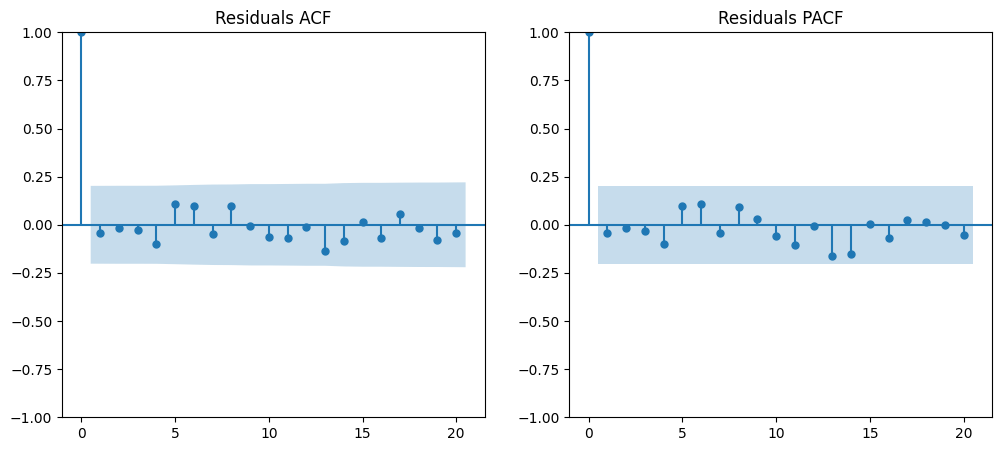

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


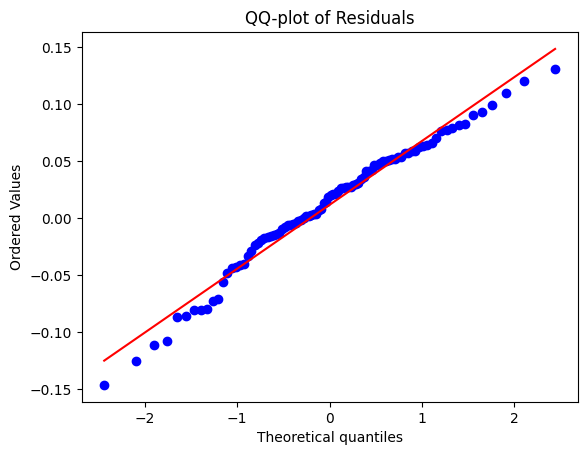

In [6]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(basefit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(basefit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(basefit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [7]:
mscimodel = SARIMAX(y, X_msci, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
mscifit = mscimodel.fit(disp=False, maxiter = 300)
mscifit.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   94
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 136.593
Date:                Mon, 22 Apr 2024   AIC                           -265.187
Time:                        10:35:43   BIC                           -255.014
Sample:                    04-01-2012   HQIC                          -261.078
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
msci           0.0407      0.107      0.382      0.703      -0.168       0.250
ar.L1         -0.6074      0.363     -1.672      0.095      -1.319       0.105
ma.L1          0.7453      0.312      2.388      0.017       0.134       1.357
sigma2         0.0032      0.001      6.158      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 3.81
Prob(Q):                              0.64   Prob(JB):                         0.15
Heteroskedasticity (H):               1.59   Skew:                            -0.49
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
acorr_ljungbox(mscifit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,5.501045,0.855299


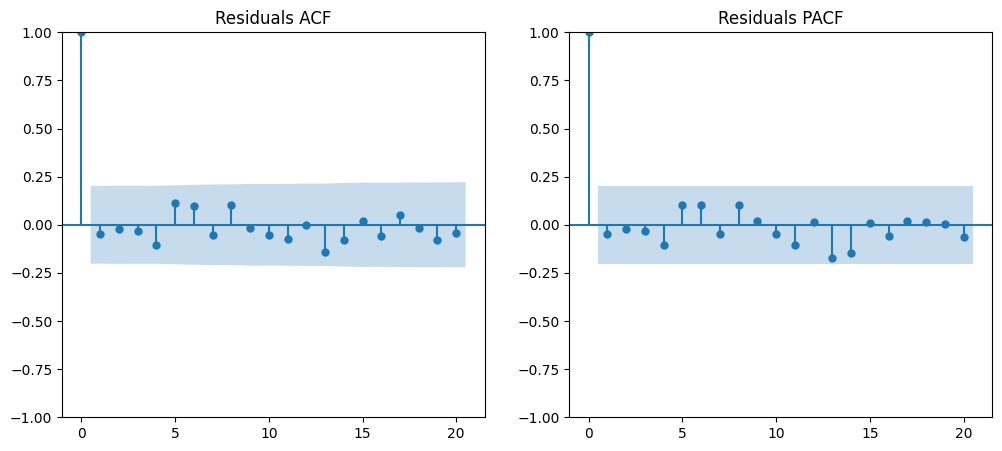

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


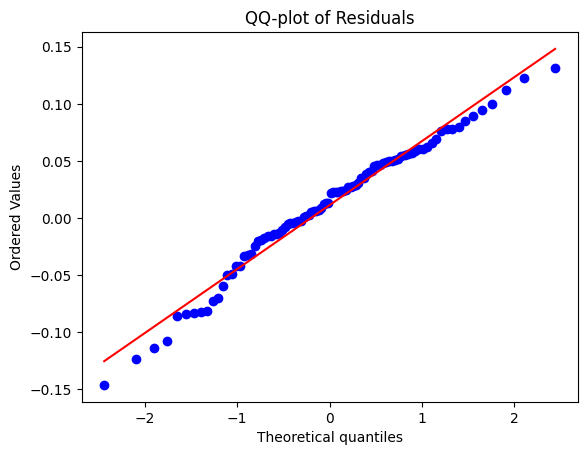

In [9]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(mscifit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(mscifit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(mscifit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [10]:
sentmodel = SARIMAX(y, X_sent, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
sentfit = sentmodel.fit(disp=False, maxiter = 300)
sentfit.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   94
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 136.494
Date:                Mon, 22 Apr 2024   AIC                           -264.989
Time:                        10:35:43   BIC                           -254.816
Sample:                    04-01-2012   HQIC                          -260.880
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sentiment     -0.0016      0.013     -0.124      0.901      -0.028       0.024
ar.L1         -0.6157      0.365     -1.689      0.091      -1.330       0.099
ma.L1          0.7492      0.312      2.398      0.016       0.137       1.361
sigma2         0.0032      0.001      6.230      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                 3.90
Prob(Q):                              0.67   Prob(JB):                         0.14
Heteroskedasticity (H):               1.60   Skew:                            -0.50
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
acorr_ljungbox(sentfit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,5.016375,0.890081


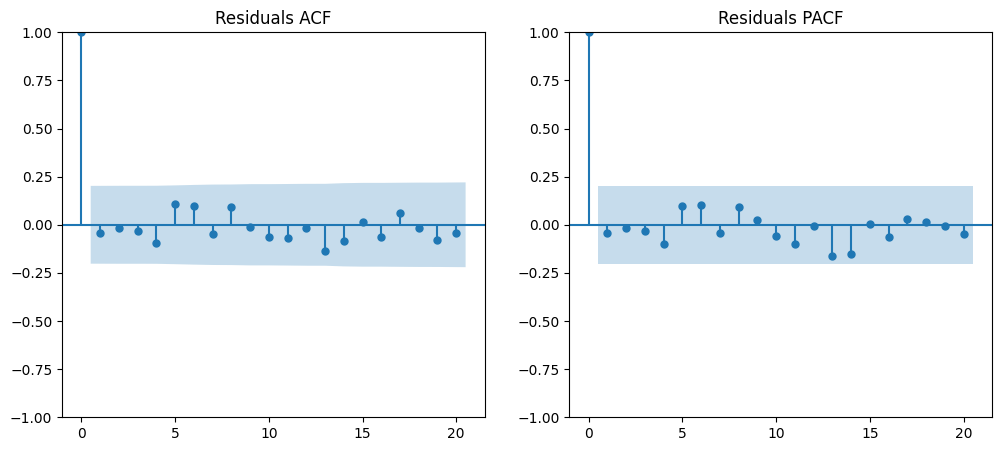

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


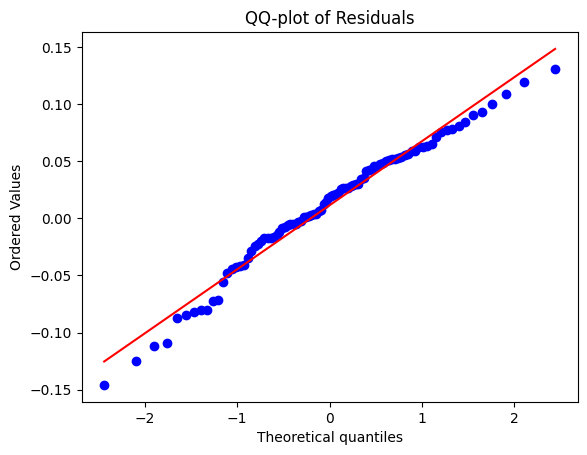

In [12]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(sentfit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(sentfit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(sentfit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

In [13]:
bothmodel = SARIMAX(y, X_both, order=(1, 0, 1), enforce_stationarity=True, enforce_invertibility=True)
bothfit = bothmodel.fit(disp=False, maxiter = 300)
bothfit.summary()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   94
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 136.608
Date:                Mon, 22 Apr 2024   AIC                           -263.217
Time:                        10:35:44   BIC                           -250.500
Sample:                    04-01-2012   HQIC                          -258.080
                         - 01-01-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
msci           0.0424      0.108      0.394      0.694      -0.169       0.254
sentiment     -0.0024      0.014     -0.179      0.858      -0.029       0.024
ar.L1         -0.6017      0.362     -1.661      0.097      -1.312       0.108
ma.L1          0.7423      0.309      2.398      0.016       0.136       1.349
sigma2         0.0032      0.001      6.168      0.000       0.002       0.004
===================================================================================
Ljung-Box (L1) (Q):                   0.20   Jarque-Bera (JB):                 3.75
Prob(Q):                              0.66   Prob(JB):                         0.15
Heteroskedasticity (H):               1.60   Skew:                            -0.49
Prob(H) (two-sided):                  0.20   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
acorr_ljungbox(bothfit.resid, lags=[10], return_df=False)

,lb_stat,lb_pvalue
10,5.379029,0.864464


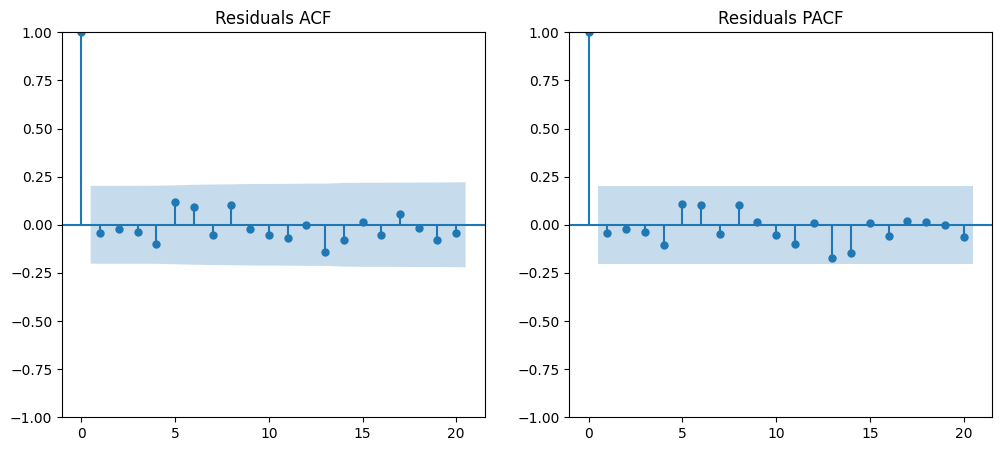

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


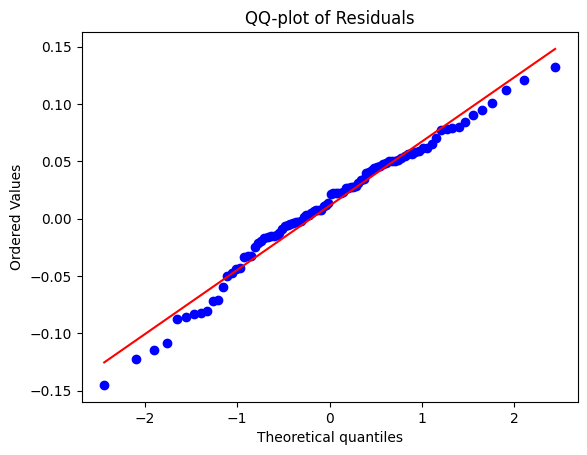

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_acf(bothfit.resid, ax=plt.gca(), title='Residuals ACF')
plt.subplot(122)
plot_pacf(bothfit.resid, ax=plt.gca(), title='Residuals PACF')
plt.show()

# QQ-plot to check for normality
plt.figure()
probplot(bothfit.resid, dist="norm", plot=plt)
plt.title('QQ-plot of Residuals')
plt.show()

Indeed, the identified best performing models seem to fit the log return series well. In the next section, we will compare their fit based on their out-of-sample performance. Finally, their accuracy in predicting the correct return sign will be assessed.

In [16]:
pbase = basefit.get_forecast(steps=len(ytest), exog=None).predicted_mean
pmsci = mscifit.get_forecast(steps=len(ytest), exog=Xmsci_test).predicted_mean
psent = sentfit.get_forecast(steps=len(ytest), exog=Xsent_test).predicted_mean
pboth = bothfit.get_forecast(steps=len(ytest), exog=Xboth_test).predicted_mean

errors = {
    'Model': ['Base', 'MSCI', 'Sentiment', 'Both'],
    'MAPE': [mape(ytest, pbase), mape(ytest, pmsci), mape(ytest, psent), mape(ytest, pboth)],
    'RMSE': [rmse(ytest, pbase), rmse(ytest, pmsci), rmse(ytest, psent), rmse(ytest, pboth)]
}

results_df = pd.DataFrame(errors)
print(results_df)

       Model        MAPE      RMSE
0       Base   99.989574  0.095453
1       MSCI  100.982024  0.096150
2  Sentiment  100.879665  0.095388
3       Both  104.128109  0.096089


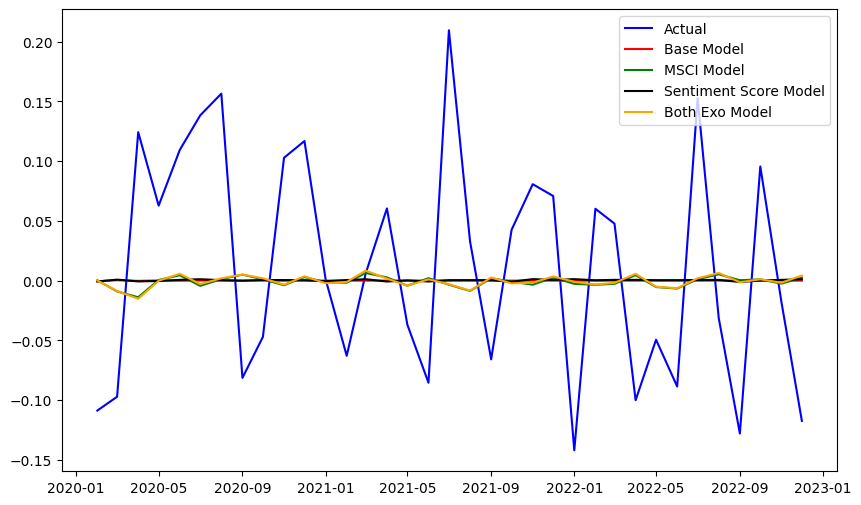

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, ytest, label='Actual', color='blue')
plt.plot(test.index, pbase, label='Base Model', color='red')
plt.plot(test.index, pmsci, label='MSCI Model', color='green')
plt.plot(test.index, psent, label='Sentiment Score Model', color='black')
plt.plot(test.index, pboth, label='Both Exo Model', color='orange')
plt.legend()

In [18]:
portfolio = pd.read_csv("./tsdata/portfolio.csv", index_col='Date', parse_dates=True)
df.index.freq = "MS"
log_returns = np.log(portfolio["0"] / portfolio["0"].shift(1)).dropna()


p_train = portfolio[:'2020-01-01']
p_test = portfolio['2020-01-02':]

predictions = pd.DataFrame()
predictions["Actual"] = log_returns['2020-01-02':].values
predictions["Base"]= pbase.values
predictions["Msci"]= pmsci.values
predictions["Sent"]= psent.values
predictions["Both"]= pboth.values

sign_comparison = predictions[['Base', 'Msci', 'Sent', 'Both']].apply(lambda x: x * predictions['Actual'] > 0)
summary_table = sign_comparison.sum().to_frame(name='Count of True')
summary_table['Percentage of True'] = (sign_comparison.mean() * 100).round(2).astype(str) + '%'

print("Sign Comparison Table:")
print(sign_comparison)
print("\nSummary Table:")
print(summary_table)

Sign Comparison Table:
     Base   Msci   Sent   Both
0    True  False   True  False
1   False   True  False   True
2   False  False  False  False
3    True   True  False  False
4   False   True   True   True
5    True  False   True  False
6   False   True   True   True
7   False  False   True  False
8    True  False  False  False
9    True  False   True  False
10  False   True   True   True
11   True  False  False  False
12   True   True  False   True
13   True   True   True   True
14  False   True  False   True
15  False   True  False   True
16   True  False   True  False
17   True  False   True  False
18  False  False   True  False
19  False  False  False  False
20  False  False  False  False
21   True  False   True  False
22  False   True   True   True
23  False   True  False   True
24  False  False   True  False
25   True  False   True  False
26   True  False  False  False
27  False   True  False   True
28   True   True  False   True
29   True   True   True   True
30   True  False

As can be seen from the results, the model with our own sentiment score performs best in terms of RMSE, predicting the correct return sign more than 50% of the time. This is not the case for any of the other specifications. In conclusion, our proprietary sentiment score seems to contain information that can be used to exploit violations of the efficient market hypothesis. As proven, our sentiment score entails more information than conventional sentiment indices. Given this, one can assume that the sentiment score might improve phone sales prediction themselves.
